# Machine Shop Example

https://simpy.readthedocs.io/en/latest/examples/machine_shop.html

In [55]:
"""
Machine shop example

Covers:

- Interrupts
- Resources: PreemptiveResource

Scenario:
  A workshop has *n* identical machines. A stream of jobs (enough to
  keep the machines busy) arrives. Each machine breaks down
  periodically. Repairs are carried out by one repairman. The repairman
  has other, less important tasks to perform, too. Broken machines
  preempt theses tasks. The repairman continues them when he is done
  with the machine repair. The workshop works continuously.

"""

'\nMachine shop example\n\nCovers:\n\n- Interrupts\n- Resources: PreemptiveResource\n\nScenario:\n  A workshop has *n* identical machines. A stream of jobs (enough to\n  keep the machines busy) arrives. Each machine breaks down\n  periodically. Repairs are carried out by one repairman. The repairman\n  has other, less important tasks to perform, too. Broken machines\n  preempt theses tasks. The repairman continues them when he is done\n  with the machine repair. The workshop works continuously.\n\n'

In [56]:
import random
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [255]:
REPAIR_TIME = 30.0     # Time it takes to repair a machine in minutes
JOB_DURATION = 30.0    # Duration of other jobs in minutes
NUM_MACHINES = 2      # Number of machines in the machine shop
WEEKS = 4              # Simulation time in weeks
SIM_TIME = WEEKS * 7 * 24 * 60  # Simulation time in minutes

In [256]:
# PT_MEAN - Avg. processing time in minutes
# PT_SIGMA - Sigma of processing time
# MTTF - Mean time to failure in minutes
machineClasses = {'A': 
                  {'PT_MEAN': 10.0,
                   'PT_SIGMA': 2.0,
                   'MTTF': 300.0},
                  'B':
                  {'PT_MEAN': 10.0,
                   'PT_SIGMA': 2.0,
                   'MTTF': 400.0},
                  'C':
                  {'PT_MEAN': 10.0,
                   'PT_SIGMA': 2.0,
                   'MTTF': 50.0}
                 }

In [257]:
# Choose random machine classification
def randMachineClass():
    return random.choice(list(machineClasses.keys()))

In [258]:
class Machine(object):
    """A machine produces parts and my get broken every now and then.

    If it breaks, it requests a *repairman* and continues the production
    after the it is repaired.

    A machine has a *name*, classification and a numberof *parts_made* thus far.

    """
    def __init__(self, env, name, classification, repairman):
        self.env = env
        self.name = name
        self.classification = classification
        self.parts_made = 0
        self.broken = False
        
        self.obsTime = []
        self.failObsTime = []
        self.repairObsTime = []
        
        
        # Start "working" and "break_machine" processes for this machine.
        self.process = env.process(self.working(repairman))
        env.process(self.break_machine())
        env.process(self.observe())
                

    def working(self, repairman):
        """Produce parts as long as the simulation runs.

        While making a part, the machine may break multiple times.
        Request a repairman when this happens.

        """
        while True:
            # Start making a new part
            done_in = self.time_per_part()
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    yield self.env.timeout(done_in)
                    done_in = 0  # Set to 0 to exit while loop.

                except simpy.Interrupt:
#                     print(f'Machine {self.name} ({self.classification}) broke at {env.now}')
                    self.failObsTime.append([env.now, 1])
                    
                    self.broken = True
                    done_in -= self.env.now - start  # How much time left?

                    # Request a repairman. This will preempt its "other_job".
                    with repairman.request(priority=1) as req:
                        yield req
                        yield self.env.timeout(REPAIR_TIME)

                    self.broken = False
                    self.repairObsTime.append([env.now, 0])

            # Part is done.
            self.parts_made += 1

    def break_machine(self):
        """Break the machine every now and then."""
        while True:
            yield self.env.timeout(self.time_to_failure())
            if not self.broken:
                # Only break the machine if it is currently working.
                self.process.interrupt()
                
    def time_per_part(self):
        """Return actual processing time for a concrete part."""
        return random.normalvariate(machineClasses[self.classification]['PT_MEAN'], machineClasses[self.classification]['PT_SIGMA'])
    
    def time_to_failure(self):
        """Return time until next failure for a machine."""
        BREAK_MEAN = 1/machineClasses[self.classification]['MTTF']   # Param. for expovariate distribution
        return random.expovariate(BREAK_MEAN)

    def observe(self):
        while True:
            self.obsTime.append([env.now, self.broken])
            yield env.timeout(1.0) # measure every 1 timestep

In [259]:
def other_jobs(env, repairman):
    """The repairman's other (unimportant) job."""
    while True:
        # Start a new job
        done_in = JOB_DURATION
        while done_in:
            # Retry the job until it is done.
            # It's priority is lower than that of machine repairs.
            with repairman.request(priority=2) as req:
                yield req
                try:
                    start = env.now
                    yield env.timeout(done_in)
                    done_in = 0
                except simpy.Interrupt:
                    done_in -= env.now - start

In [260]:
# Setup and start the simulation
print('Machine shop')
random.seed(RANDOM_SEED)  # This helps reproducing the results

Machine shop


In [261]:
# Create an environment and start the setup process
env = simpy.Environment()
repairman = simpy.PreemptiveResource(env, capacity=1)
machines = [Machine(env, 'Machine %d' % i, randMachineClass(), repairman) for i in range(NUM_MACHINES)]
env.process(other_jobs(env, repairman))

<Process(other_jobs) object at 0x184333ff898>

In [262]:
env.process(observe(env))

<Process(observe) object at 0x18434e053c8>

In [263]:
# Execute!
env.run(until=SIM_TIME)

In [264]:
# Analyis/results
print('Machine shop results after %s weeks' % WEEKS)
for machine in machines:
    print(f'{machine.name} ({machine.classification}) made {machine.parts_made} parts.')

Machine shop results after 4 weeks
Machine 0 (C) made 2383 parts.
Machine 1 (A) made 3607 parts.


In [265]:
def systemStats(machines):
    return np.array([machine.parts_made for machine in machines]).mean()

In [266]:
systemStats(machines)

2995.0

In [267]:
dfStore = pd.DataFrame()
for machine in machines:
    time = [record[0] for record in machine.obsTime]
    state = [record[1] for record in machine.obsTime]
    
    df = pd.DataFrame(data={'machine': machine.name, 'class': machine.classification,
                           'time': time, 'state': state})
    
    dfStore = pd.concat([dfStore, df])

In [268]:
dfStore.head()

,machine,class,time,state
0,Machine 0,C,0.0,False
1,Machine 0,C,1.0,False
2,Machine 0,C,2.0,False
3,Machine 0,C,3.0,False
4,Machine 0,C,4.0,False


In [269]:
# Calculate system availability (assumption - linear model)
dfSystemState = dfStore.groupby(['time'])['state'].sum()

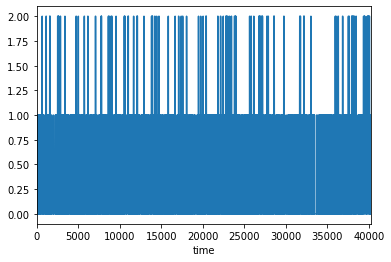

In [270]:
dfSystemState.plot()

In [271]:
# Number of zero events where all machines are in operating state
(dfSystemState == 0).astype(int).sum()

21583

In [272]:
availability = ((dfSystemState == 0).astype(int).sum()/SIM_TIME) * 100
print(f'{availability:0.2f}%')

53.53%


# Goal is to try and learn that machine 'A' is the best one

## Assumption: System is a linear combination of machines